In [42]:
import numpy as np
from scipy.optimize import curve_fit
import scipy.integrate as spi
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import glob
from uncertainties import ufloat

In [11]:
def line(x, m, b):
    return m*x+b

def gaussian(x, A0, x0, sigma): #A0 intensidad, X0 centroide.
    return A0 * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def sum_gaussian_bg_lin(x, A1, x1, sigma1, m, b):
    return gaussian(x, A1, x1, sigma1)+line(x, m, b)

def sum_twogaussian_bg_l(x, A1, x1, sigma1, A2, x2, sigma2, m, b):
    return gaussian(x, A1, x1, sigma1) + gaussian(x, A2, x2, sigma2) + line(x, m,b)

def SinglePeak_lfit(x, y): #y:peso, intensidad, cuentas
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    m = (y[-1]-y[0])/(x[-1]-x[0])
    b = y[0]-m*x[0]
    dy = np.sqrt(y) #incertidumbre, poisson 
    dy[:] += 1 #para asegurar que todos los valores sean mayores que cero, div 0
    bounds_param = ([0,0,0,-np.inf,-np.inf],[np.inf,np.inf,np.inf,np.inf,np.inf]) #5 param, 3 gaussiana, 2 linea recta
    popt, pcov = curve_fit(sum_gaussian_bg_lin, x, y, sigma=dy, p0=[max(y)-min(y), mean, sigma, m, b],bounds = bounds_param)
    return popt, pcov

def DoublePeak_fit(x, y):
    x1=x[:int(len(x)/2)] #dividiendo los datos en dos partes, una mitad para cada gaussiana
    y1=y[:int(len(x)/2)]
    x2=x[int(len(x)/2):]
    y2=y[int(len(x)/2):]
    
    A1 = max(y1)-min(y1)
    mu1 = sum(x1 * y1) / sum(y1)
    s1 = np.sqrt(sum(y1 * (x1 - mu1) ** 2) / sum(y1))
    A2 = max(y2)-min(y2)
    mu2 = sum(x2 * y2) / sum(y2)
    s2 = np.sqrt(sum(y2 * (x2 - mu2) ** 2) / sum(y2))

    m = 0.1 #parametros de inicializacion fijos
    b = 10
    bounds_param = ([0,0,0,0,0,0,-np.inf,-np.inf],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf])
    dy = np.sqrt(y)
    dy[:] += 1
    popt, pcov = curve_fit(sum_twogaussian_bg_l, x, y, sigma=dy, p0=[A1, mu1, s1, A2, mu2, s2, m, b],bounds = bounds_param)
    return popt, pcov

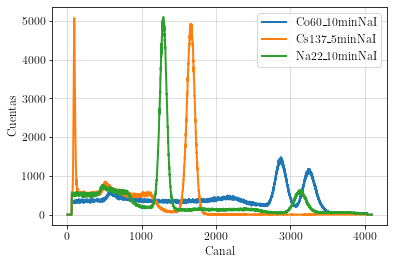

In [12]:
path = './data/' 
name = '*csv'
list_of_files = glob.glob(path+name) #leer todos los archivos de una direccion, comandos de una terminal
##@ Read files # CHECKED
dicData = {} #Key:fileName Value:spectrum values

for file_name in list_of_files: #leer archivos, .dat y csv
    Es = np.genfromtxt(file_name, skip_header=1, skip_footer=0, dtype=float,\
                        delimiter=',')
    if (not file_name[len(path):-4] in dicData.keys()  > -1):
        dicData[file_name[len(path):-4]] = Es

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

plt.xlabel(r'Canal') #
plt.ylabel(r'Cuentas')
plt.grid(which='both',alpha=0.5)

#plt.xlim(20,300)
#plt.ylim(400,3000)
# plt.yscale('log') #gaussiana en log deberia verse como una parabola
for key in  dicData.keys():
    plt.plot(np.asarray(dicData[key])[:,0],np.asarray(dicData[key])[:,1],lw=2,label=key)

plt.legend(title=r"", loc=0, fontsize="12" )
plt.show()



In [72]:
#Calibracion
energias=np.array([32.8,511,661.7,1173.2,1274.5,1332.5])
canales=np.array([93.28,1290.79,1661.56,2873.01,3132.70,3256.57])

def E(canal,a0,a1):
    return a1*canal+a0
    
fitE=curve_fit(E,canales,energias)
argsE=fitE[0]
errorargsE=np.sqrt(np.diag(fitE[1]))
Ecanales=E(x_E_array,*argsE)

4096


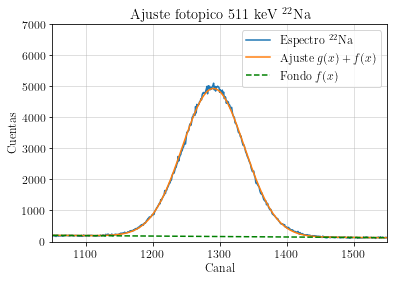

In [54]:
params = {}

## 22Na ##

key = 'Na22_10minNaI'
x_E_array = np.asarray(dicData[key])[:,0]
y_I_array = np.asarray(dicData[key])[:,1]

plt.xlabel(r'Canal')
plt.ylabel(r'Cuentas')    
plt.title(r'Ajuste fotopico 511 keV $^{22}$Na')
plt.xlim(1050,1550)
plt.ylim(0,7000)
plt.plot(x_E_array,y_I_array, label=r'Espectro $^{22}$Na')
plt.grid(which='both',alpha=0.5)
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0),useOffset=True)

#! 511 keV peak
roi_min,roi_max = 1050,1550
roi = [roi_min,roi_max]

popt,pcov = SinglePeak_lfit(x_E_array[roi[0]:roi[1]],y_I_array[roi[0]:roi[1]])
perr = np.sqrt(np.diag(pcov))
param_name = key+'_511keV'
params[param_name]=[511,popt[0],popt[1],popt[2],perr[0],perr[1],perr[2]] #intensidad, centroide, sigma, y errores asociados

plt.plot(x_E_array[roi[0]:roi[1]], sum_gaussian_bg_lin(x_E_array[roi[0]:roi[1]],popt[0],popt[1],popt[2],popt[3],popt[4]), label=r'Ajuste $g(x)+f(x)$')
plt.plot(x_E_array[roi[0]:roi[1]], line(x_E_array[roi[0]:roi[1]],popt[3], popt[4]), c='green', linestyle='--', label=r'Fondo $f(x)$')

plt.gcf().set_facecolor('white')
plt.legend(loc=0,title=r"")
# plt.savefig('fotopicoNa511.png', dpi=300)
plt.show()

sigma1=ufloat(popt[2], perr[2])
mu1_Na=ufloat(popt[1],perr[1])
M1=ufloat(popt[0],perr[0])



In [61]:
# 511 keV cuentas
area511=M1*sigma1*np.sqrt(2*np.pi)
area511

552787.0072363879+/-1380.694357902656

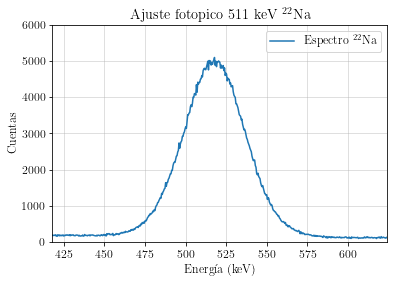

418.58975329278223 624.49842042228


In [82]:
#Espectro con calibracion de energias 511 keV
plt.plot(Ecanales,y_I_array, label=r'Espectro $^{22}$Na')
plt.xlabel(r'Energía (keV)')
plt.ylabel(r'Cuentas')    
plt.title(r'Ajuste fotopico 511 keV $^{22}$Na')
plt.xlim(418,624) #Cambiar xlim por el equivalente en keV #print(E(2840,*argsE),E(3650,*argsE))
plt.ylim(0,6000)
plt.grid(which='both',alpha=0.5)
plt.legend(loc=0,title=r"")
# plt.savefig('fotopicoNa1275.png', dpi=300)
plt.show()

print(E(1050,*argsE),E(1550,*argsE))

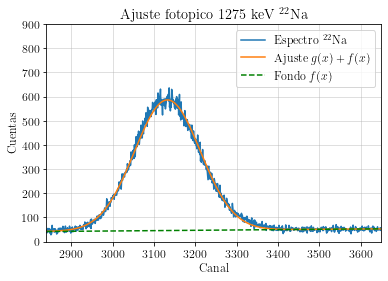

In [62]:
#! 1275 keV peak
roi_min,roi_max = 2840,3650
roi = [roi_min,roi_max]

plt.xlabel(r'Canal')
plt.ylabel(r'Cuentas')    
plt.title(r'Ajuste fotopico 1275 keV $^{22}$Na')
plt.xlim(2840,3650)
plt.ylim(0,900)
plt.plot(x_E_array,y_I_array, label=r'Espectro $^{22}$Na')
plt.grid(which='both',alpha=0.5)

popt,pcov = SinglePeak_lfit(x_E_array[roi[0]:roi[1]],y_I_array[roi[0]:roi[1]]) # popt= A1, x1, sigma1, m, b
perr = np.sqrt(np.diag(pcov))
param_name = key+'_1275keV'
params[param_name]=[1274.6,popt[0],popt[1],popt[2],perr[0],perr[1],perr[2]]

plt.plot(x_E_array[roi[0]:roi[1]], sum_gaussian_bg_lin(x_E_array[roi[0]:roi[1]],popt[0],popt[1],popt[2],popt[3],popt[4]), label=r'Ajuste $g(x)+f(x)$')
plt.plot(x_E_array[roi[0]:roi[1]], line(x_E_array[roi[0]:roi[1]],popt[3], popt[4]), c='green', linestyle='--', label=r'Fondo $f(x)$')


plt.gcf().set_facecolor('white')
plt.legend(loc=0,title=r"")
# plt.savefig('fotopicoNa1275.png', dpi=300)
plt.show()

mu2_Na=popt[1]


sigma2=ufloat(popt[2], perr[2])
mu2_Na=ufloat(popt[1],perr[1])
M2=ufloat(popt[0],perr[0])

In [63]:
# 1275 keV cuentas
area1275=M2*sigma2*np.sqrt(2*np.pi)
area1275

107941.36947356128+/-618.7313745681043

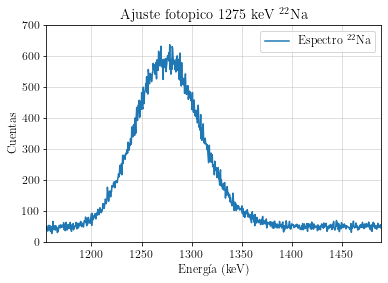

1155.7427816163838 1489.3148223661701


In [77]:
#Espectro con calibracion de energias 1275 keV
plt.plot(Ecanales,y_I_array, label=r'Espectro $^{22}$Na')
plt.xlabel(r'Energía (keV)')
plt.ylabel(r'Cuentas')    
plt.title(r'Ajuste fotopico 1275 keV $^{22}$Na')
plt.xlim(1155,1489) #Cambiar xlim por el equivalente en keV #print(E(2840,*argsE),E(3650,*argsE) )
plt.ylim(0,700)
plt.grid(which='both',alpha=0.5)
plt.legend(loc=0,title=r"")
# plt.savefig('fotopicoNa1275.png', dpi=300)
plt.show()

In [84]:
#Rexp = I511 / I1275 (incertidumbre)

Rexp = area511/area1275

5.121178376116354+/-0.03202089377729354